/opt/anaconda3/lib/python3.12/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/opt/anaconda3/lib/python3.12/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))



Photon Counts Through TOLIMAN Aperture for Different Exposure Times:
Exposure Time: 1 seconds -> Photon Count: 1.70e+04 photons -> Log Scale: 4.23
Exposure Time: 100 seconds -> Photon Count: 1.70e+06 photons -> Log Scale: 6.23
Exposure Time: 1000 seconds -> Photon Count: 1.70e+07 photons -> Log Scale: 7.23
Exposure Time: 10000 seconds -> Photon Count: 1.70e+08 photons -> Log Scale: 8.23


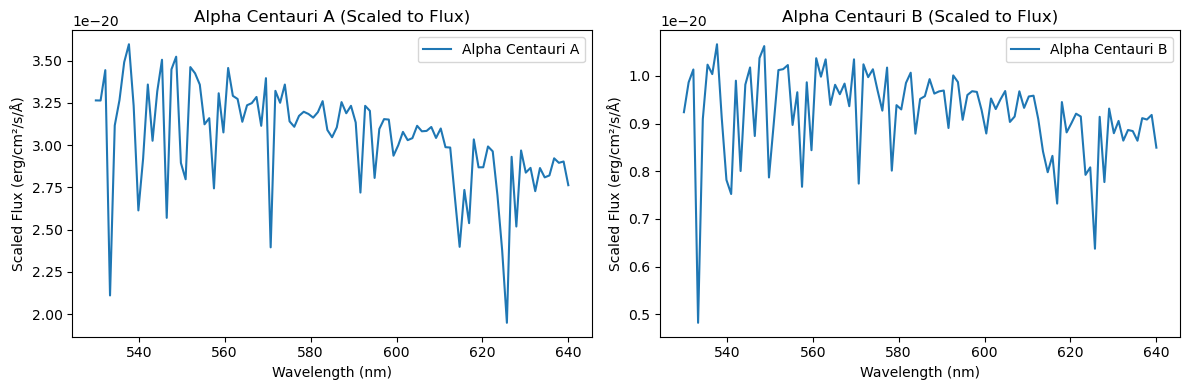

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysynphot as S

# Constants
h = 6.626e-34  # Planck's constant, J*s
c = 3.0e8      # Speed of light, m/s
telescope_radius = 6.5  # Telescope radius in cm
aperture_area = np.pi * (telescope_radius ** 2)  # Aperture area in cm²
f0_V = 3.63e-20  # Reference flux for magnitude 0 in the V band (erg/cm²/s/Å)

# Stellar properties for Alpha Centauri A and B
ALPHA_CEN_A = {"temp": 5770.0, "metal": 0.2, "grav": 4.0}
ALPHA_CEN_B = {"temp": 5350.0, "metal": 0.23, "grav": 4.37}

# Apparent magnitudes for Alpha Centauri A and B
magnitude_A = 0.01  # Alpha Centauri A apparent magnitude in V band
magnitude_B = 1.33  # Alpha Centauri B apparent magnitude in V band

# Define wavelength grid for TOLIMAN bandpass (530-640 nm)
spec_wavelengths = np.linspace(530, 640, 101) * 1e-9  # Convert nm to meters


def get_normalized_spectrum(star_properties, wavelengths):
    """Generate a normalized spectrum for a star given its properties."""
    temp = star_properties["temp"]
    metal = star_properties["metal"]
    grav = star_properties["grav"]
    
    # Use pysynphot to generate a blackbody spectrum
    spectrum = S.Icat("phoenix", temp, metal, grav)
    spectrum.convert('flam')  # Convert to flux per unit area
    sampled_spectrum = spectrum.sample(wavelengths * 1e10)  # Wavelengths in Angstroms for pysynphot
    return sampled_spectrum / np.max(sampled_spectrum)


def scale_spectrum_to_flux(normalized_spectrum, wavelengths, magnitude, reference_flux):
    """Scale normalized spectrum to match known flux from apparent magnitude."""
    scale_factor = 10 ** (-magnitude / 2.5)
    scaled_spectrum = normalized_spectrum * (reference_flux * scale_factor)
    return scaled_spectrum


def flux_to_photon_flux(flux, wavelengths):
    """Convert flux to photon flux (photons/cm²/s/Å)."""
    return flux * wavelengths * 1e10 / (h * c)  # Convert wavelength to cm


# Generate normalized spectra for Alpha Centauri A and B
Aspec = get_normalized_spectrum(ALPHA_CEN_A, spec_wavelengths)
Bspec = get_normalized_spectrum(ALPHA_CEN_B, spec_wavelengths)

# Scale the spectra according to the apparent magnitudes of the stars
scaled_A = scale_spectrum_to_flux(Aspec, spec_wavelengths, magnitude_A, f0_V)
scaled_B = scale_spectrum_to_flux(Bspec, spec_wavelengths, magnitude_B, f0_V)

# Convert the scaled spectra to photon flux (photons/cm²/s/Å)
A_photon_flux = flux_to_photon_flux(scaled_A, spec_wavelengths)
B_photon_flux = flux_to_photon_flux(scaled_B, spec_wavelengths)

# Calculate total photon flux (photons/cm²/s) by integrating the photon flux
total_photon_flux_A = np.trapz(A_photon_flux, spec_wavelengths)
total_photon_flux_B = np.trapz(B_photon_flux, spec_wavelengths)

# Total photon flux from both stars
total_photon_flux = total_photon_flux_A + total_photon_flux_B

# Include TOLIMAN aperture to compute total photons collected
photon_flux_through_aperture = total_photon_flux * aperture_area  # photons/s through the aperture

# Define exposure times (in seconds)
exposure_times = [1, 100, 1000, 10000]  # seconds

# Calculate photon counts for different exposure times considering the aperture


# Calculate photon counts through the aperture for different exposure times
photon_counts_aperture = [photon_flux_through_aperture * t for t in exposure_times]

# Display results for photon counts through the aperture
print("\nPhoton Counts Through TOLIMAN Aperture for Different Exposure Times:")
for t, count in zip(exposure_times, photon_counts_aperture):
    print(f"Exposure Time: {t} seconds -> Photon Count: {count:.2e} photons -> Log Scale: {np.log10(count):.2f}")




# Plot Alpha Centauri A and B spectra (scaled)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Alpha Centauri A (Scaled to Flux)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Scaled Flux (erg/cm²/s/Å)")
plt.plot(spec_wavelengths * 1e9, scaled_A, label="Alpha Centauri A")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Alpha Centauri B (Scaled to Flux)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Scaled Flux (erg/cm²/s/Å)")
plt.plot(spec_wavelengths * 1e9, scaled_B, label="Alpha Centauri B")
plt.legend()

plt.tight_layout()
plt.show()
